In [ ]:
from google.colab import files 
uploaded = files.upload()

Saving weekly_in_situ_co2_mlo.csv to weekly_in_situ_co2_mlo.csv


In [ ]:
#importing necessary libraries
import pandas as pd
import io
from datetime import datetime
import pystan
import matplotlib.pyplot as plt
import scipy.stats as sts
import numpy as np
import seaborn
from datetime import datetime
from datetime import timedelta

In [ ]:
data = pd.read_csv(io.BytesIO(uploaded['weekly_in_situ_co2_mlo.csv']))

In [ ]:
#calculating the day numbers based on the dates to use them for modeling purpose 
def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.strptime(d2, "%Y-%m-%d")
    return abs((d2 - d1).days)

days = [0]
for i in range(0, len(data)-1):
  days.append(days[-1]+days_between(data.iloc[i,0], data.iloc[i+1,0]))

In [ ]:
#adding another column with days
data['Days'] = days

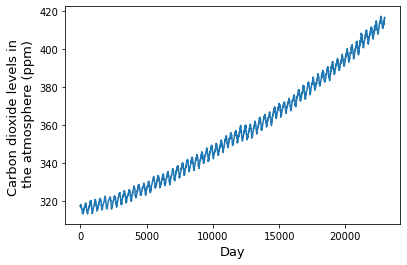

In [ ]:
plt.plot(days, data.iloc[:,1])
plt.ylabel('Carbon dioxide levels in \n the atmosphere (ppm)', size=13)
plt.xlabel('Day', size=13)
plt.show()

In [ ]:
# Plot sample autocorrelation for each parameter.
def plot_acf(x):
    '''
    Plot the autocorrelation function for a series x. This corresponds to the
    acf() function in R. The series x is detrended by subtracting the mean of
    the series before computing the autocorrelation.
    '''
    from scipy import signal    
    plt.acorr(
        x, maxlags=20, detrend=lambda x: signal.detrend(x, type='constant'))

In [ ]:
stan_code_linear = """

data {  
    int<lower=0> N_obs;      // length of the data (number of prices)
    real<lower=0> obs[N_obs];   // specific observations
    real<lower=0> day[N_obs];       // day
}

parameters {
    //parameters of the model
    real<lower=0> c0;   
    real<lower=0> c1;  
    real<lower=0, upper=10> c2;
    real<lower=0, upper=1> c3;         
    real<lower=0> sigma;            
}


model {
    //priors 
    c0 ~ cauchy(0, 1);
    c1 ~ cauchy(0, 1);
    c2 ~ cauchy(0, 1);
    c3 ~ cauchy(0, 1);
    sigma ~ cauchy(0, 1);

    //likelihood
    for (i in 1:N_obs) {
      obs[i] ~ normal(c0+c1*day[i]+c2*cos(2*pi()*day[i]/(365.25+c3)), sigma);
    }

}
"""
stan_model_linear = pystan.StanModel(model_code=stan_code_linear)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_49db1dce028ad8b3bce2656be0e98833 NOW.


In [ ]:
stan_data = {
  'N_obs': len(data),
  'obs': data.iloc[:,1],
  'day': data.iloc[:,2]
}

#extracting samples from the linear model
results_linear = stan_model_linear.sampling(data=stan_data)
linear_samples = results_linear.extract()

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


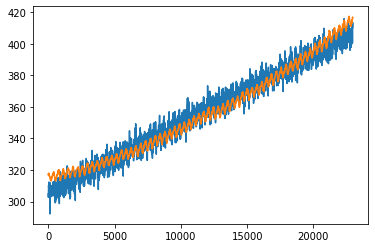

In [ ]:
#plotting the data from the linear model
#here we are sampling from a normal distribution using paramters estimated by Stan
def linear(posterior_samples, time, func):
  return np.array(sts.norm.rvs(func(posterior_samples['c0'])+
                                func(posterior_samples['c1'])*time+ 
                                func(posterior_samples['c2'])*np.cos((2*np.pi*time)/365.25+
                                func(posterior_samples['c3'])), 
                                  func(posterior_samples['sigma'])))


linear_data = linear(linear_samples, data.iloc[:,2], np.mean)
plt.plot(days, linear_data)
plt.plot(days, data.iloc[:,1])
plt.show()

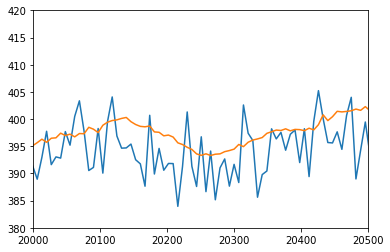

In [ ]:
#a close up of the previous plot
plt.plot(days, linear_data)
plt.plot(days, data.iloc[:,1])
plt.axis([20000, 20500, 380, 420])
plt.show()

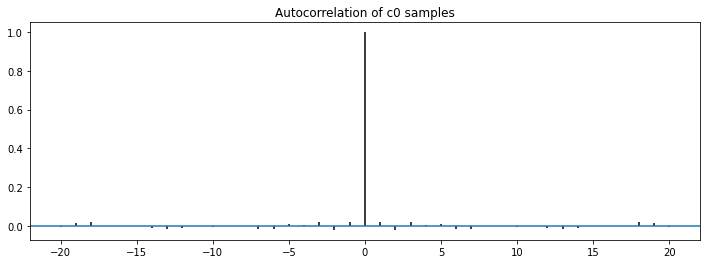

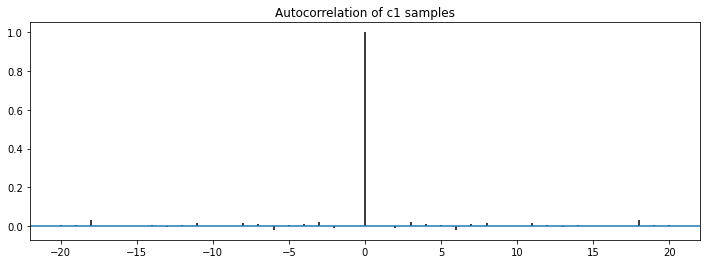

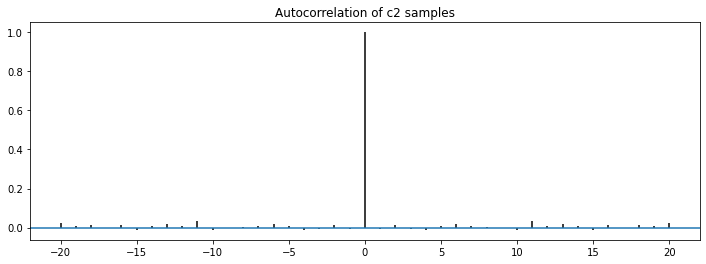

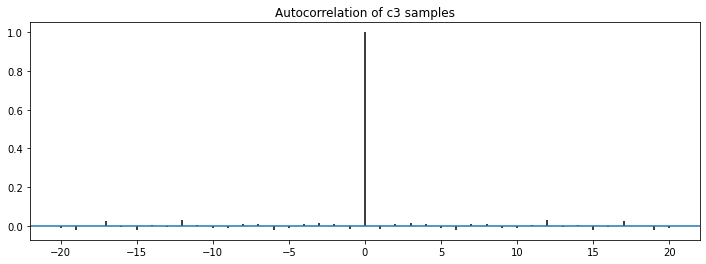

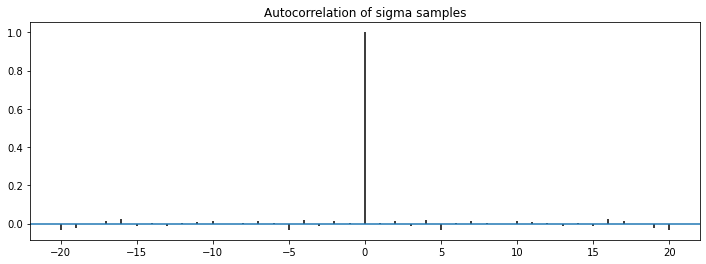

In [ ]:
#measuring autocorrelation of the samples
parameters = ['c0', 'c1', 'c2', 'c3', 'sigma']
for param in parameters:
    plt.figure(figsize=(12, 4))
    plot_acf(linear_samples[param])
    plt.title(f'Autocorrelation of {param} samples')

plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


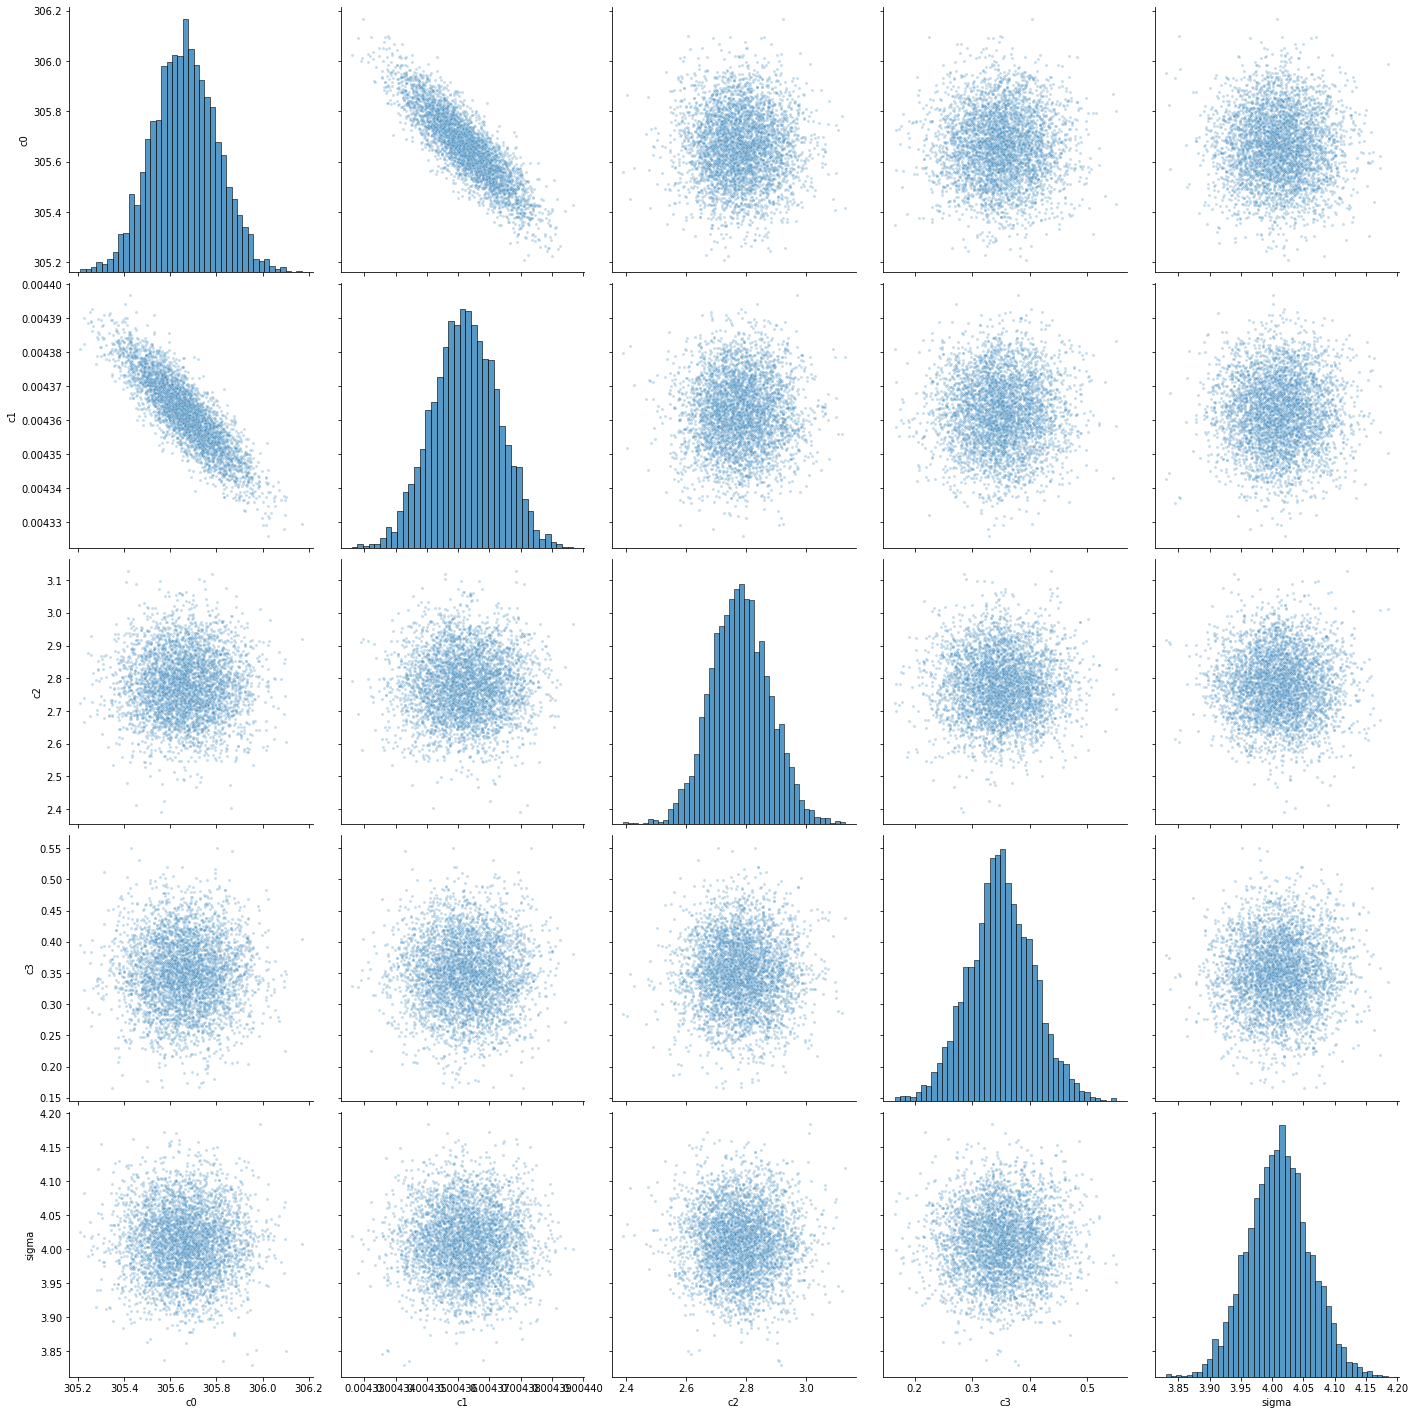

In [ ]:
#creating pairwise plots
df = pd.DataFrame(
    data=np.transpose([linear_samples[param] for param in parameters]),
    columns=parameters)
seaborn.pairplot(df, size=4, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()

In [ ]:
stan_code_quadratic = """

data {  
    int<lower=0> N_obs;      // length of the data (number of prices)
    real<lower=0> obs[N_obs];   // specific observations
    real<lower=0> day[N_obs];       // day
}

parameters {
    //parameters of the model
    real<lower=0> c0;   
    real<lower=0> c1;  
    real<lower=0, upper=10> c2;
    real<lower=0, upper=1> c3;         
    real<lower=0> sigma;            
}


model {
    //priors 
    c0 ~ cauchy(0, 1);
    c1 ~ cauchy(0, 1); 
    c2 ~ cauchy(0, 1);
    c3 ~ cauchy(0, 1);
    sigma ~ cauchy(0, 1);

    //likelihood
    for (i in 1:N_obs) {
      obs[i] ~ normal(c0+c1*(day[i]^2)+c2*cos(2*pi()*day[i]/(365.25+c3)), sigma);
    }

}
"""
stan_model_quadratic = pystan.StanModel(model_code=stan_code_quadratic)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9b5f0ad1b1dbccac64f0490392be91c7 NOW.


In [ ]:
results_quadratic = stan_model_quadratic.sampling(data=stan_data)
quadratic_samples = results_quadratic.extract()

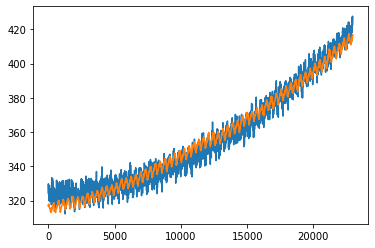

In [ ]:
#plotting the data from the quadratic model
def quadratic(posterior_samples, time, func):
  return np.array(sts.norm.rvs(func(posterior_samples['c0'])+
                                func(posterior_samples['c1'])*(time**2)+ 
                                func(posterior_samples['c2'])*np.cos((2*np.pi*time)/365.25+
                                func(posterior_samples['c3'])), 
                                  func(posterior_samples['sigma'])))


quadratic_data = quadratic(quadratic_samples, data.iloc[:,2], np.mean)
plt.plot(days, quadratic_data)
plt.plot(days, data.iloc[:,1])
plt.show()

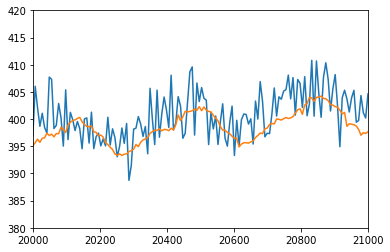

In [ ]:
plt.plot(days, quadratic_data)
plt.plot(days, data.iloc[:,1])
plt.axis([20000, 21000, 380, 420])
plt.show()

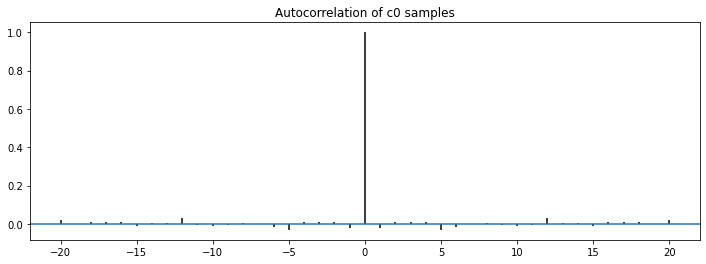

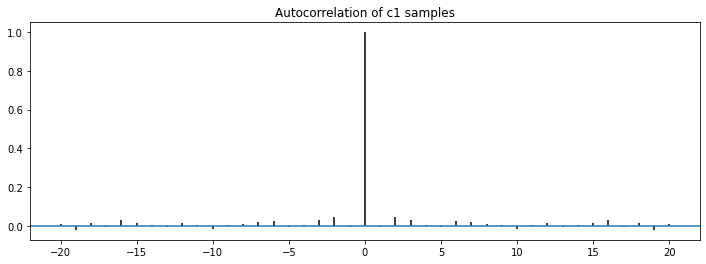

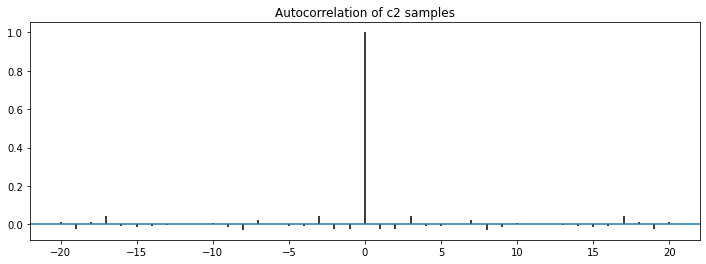

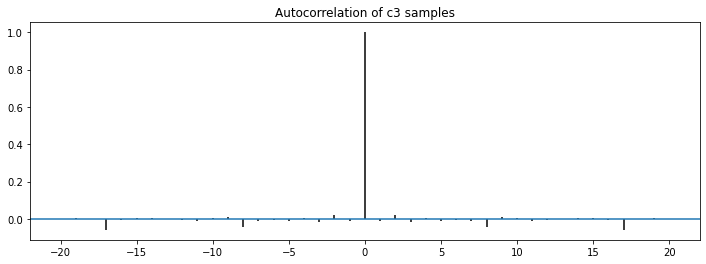

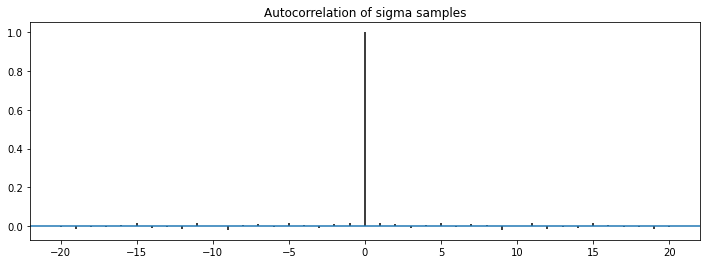

In [ ]:
for param in parameters:
    plt.figure(figsize=(12, 4))
    plot_acf(quadratic_samples[param])
    plt.title(f'Autocorrelation of {param} samples')

plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


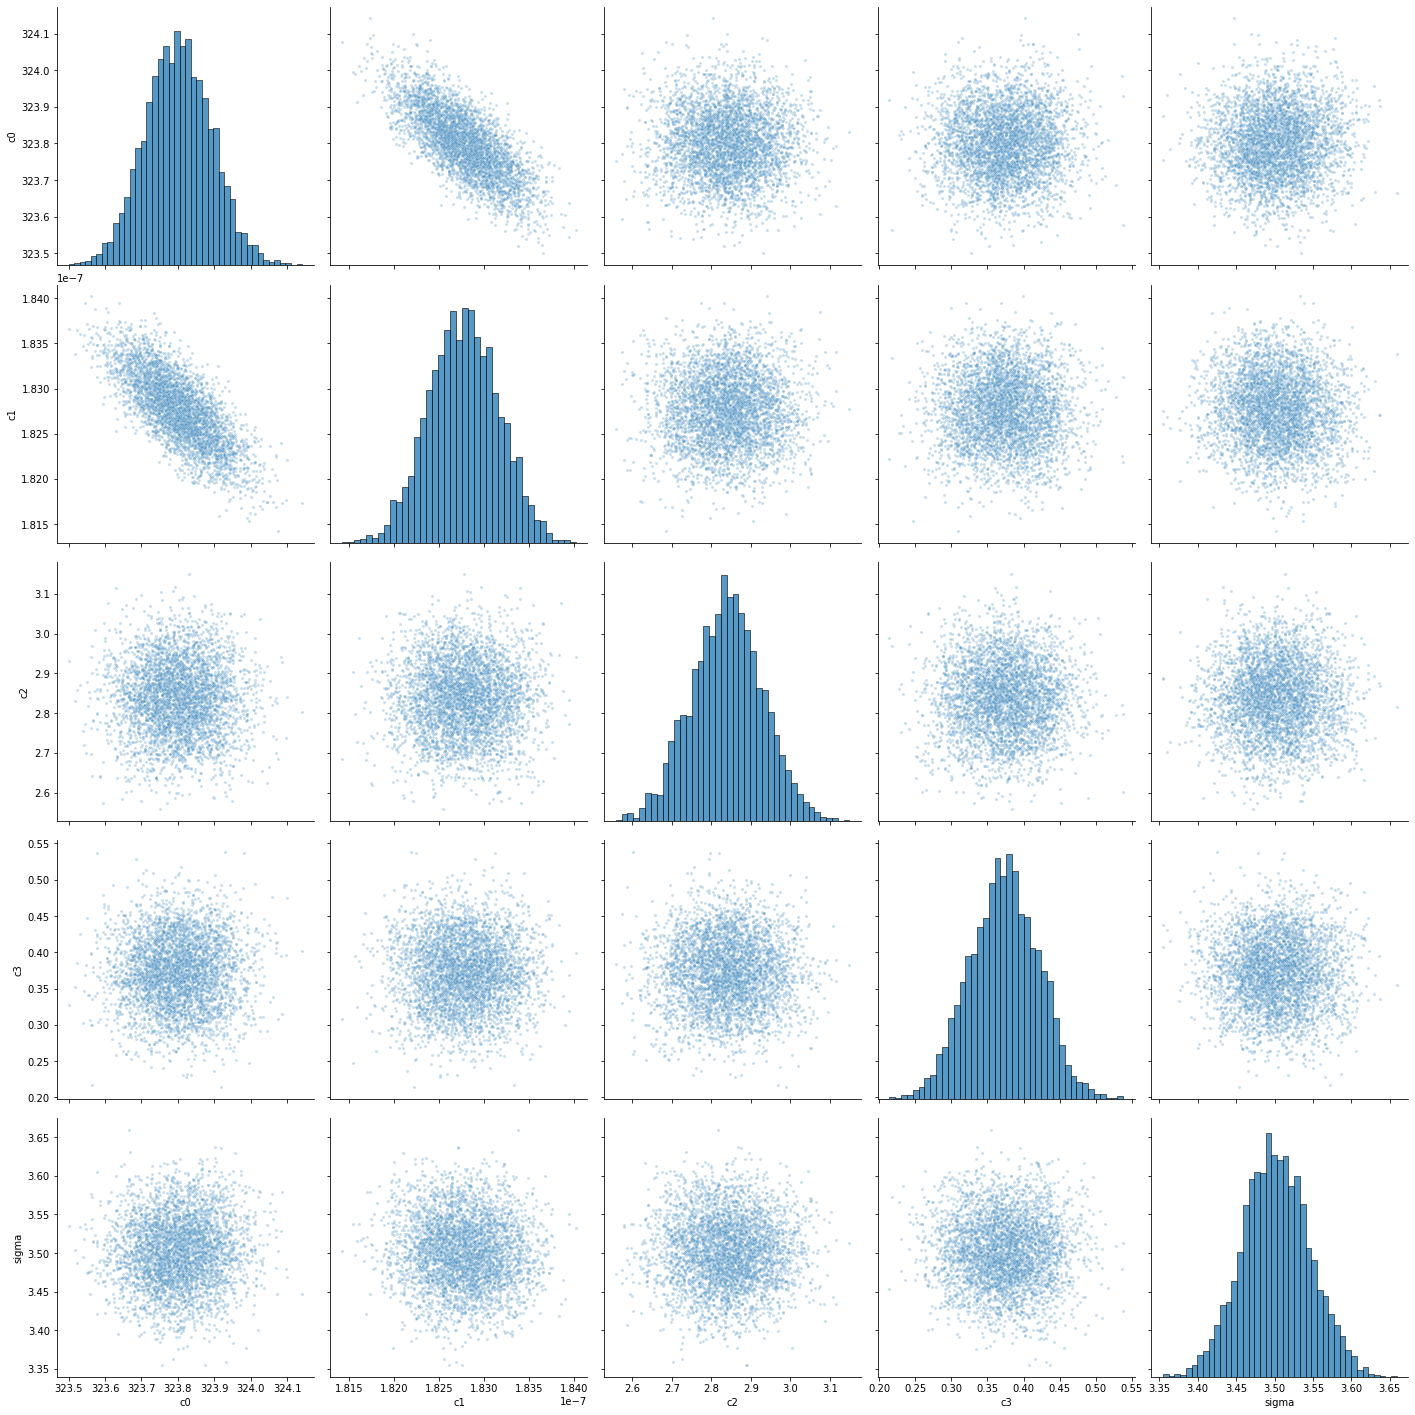

In [ ]:
df = pd.DataFrame(
    data=np.transpose([quadratic_samples[param] for param in parameters]),
    columns=parameters)
seaborn.pairplot(df, size=4, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()

In [ ]:
stan_code_ice_exponential = """

data {  
    int<lower=0> N_obs;      // length of the data (number of prices)
    real<lower=0> obs[N_obs];   // specific observations
    real<lower=0> day[N_obs];       // day
}

parameters {
    //parameters of the model
    real<lower=0> c0;   
    real<lower=0> c1;  
    real<lower=0, upper=10> c2;
    real<lower=0, upper=1> c3;          
    real<lower=0> sigma;            
}


model {
    //priors 
    c0 ~ cauchy(0, 1);
    c1 ~ cauchy(0, 1); 
    c2 ~ cauchy(0, 1);
    c3 ~ cauchy(0, 1);
    sigma ~ cauchy(0, 1);

    //likelihood
    for (i in 1:N_obs) {
      obs[i] ~ normal(c0+c1*(day[i]^1.5)+c2*cos(2*pi()*day[i]/(365.25+c3)), sigma);
    }

}
"""
stan_model_exponential = pystan.StanModel(model_code=stan_code_ice_exponential)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ef5e048d6e1158fd6ff2340b9811458d NOW.


In [ ]:
results_exponential = stan_model_exponential.sampling(data=stan_data)
exponential_samples = results_exponential.extract()

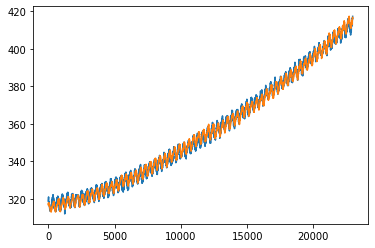

In [ ]:
#plotting the data from the exponential model
def exponential(posterior_samples, time, func):
  return np.array(sts.norm.rvs(func(posterior_samples['c0'])+
                                func(posterior_samples['c1'])*(time**1.5)+ 
                                func(posterior_samples['c2'])*np.cos((2*np.pi*time)/365.25+
                                func(posterior_samples['c3'])), 
                                  func(posterior_samples['sigma'])))


exponential_data = exponential(exponential_samples, data.iloc[:,2], np.mean)
plt.plot(days, exponential_data)
plt.plot(days, data.iloc[:,1])
plt.show()

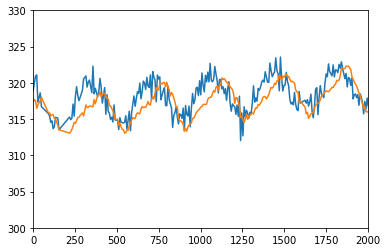

In [ ]:
plt.plot(days, exponential_data)
plt.plot(days, data.iloc[:,1])
plt.axis([0, 2000, 300, 330])
plt.show()

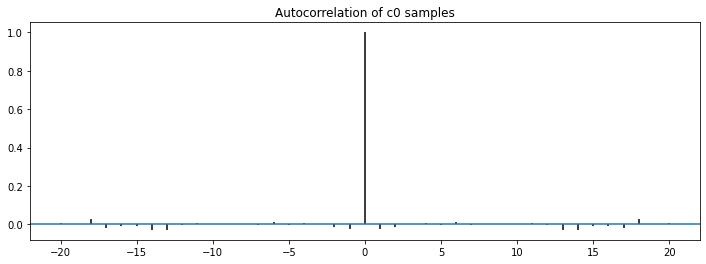

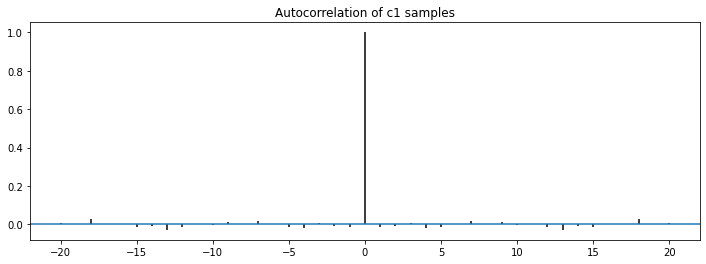

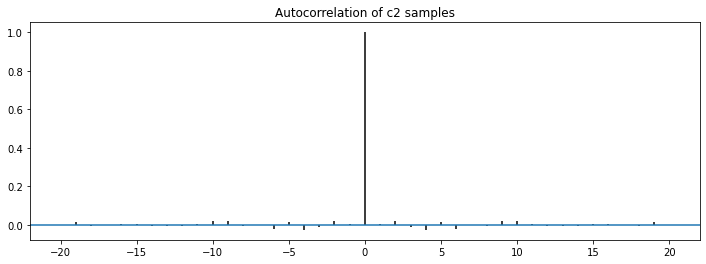

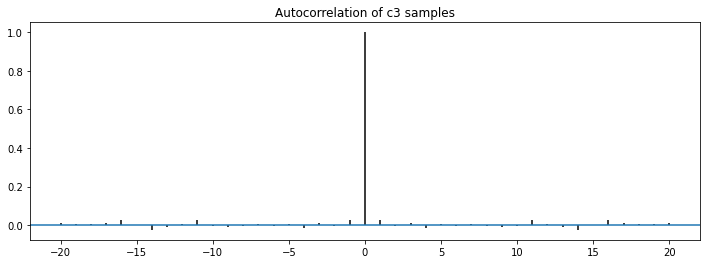

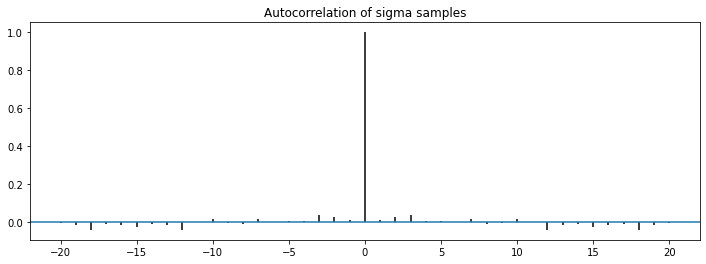

In [ ]:
for param in parameters:
    plt.figure(figsize=(12, 4))
    plot_acf(exponential_samples[param])
    plt.title(f'Autocorrelation of {param} samples')

plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


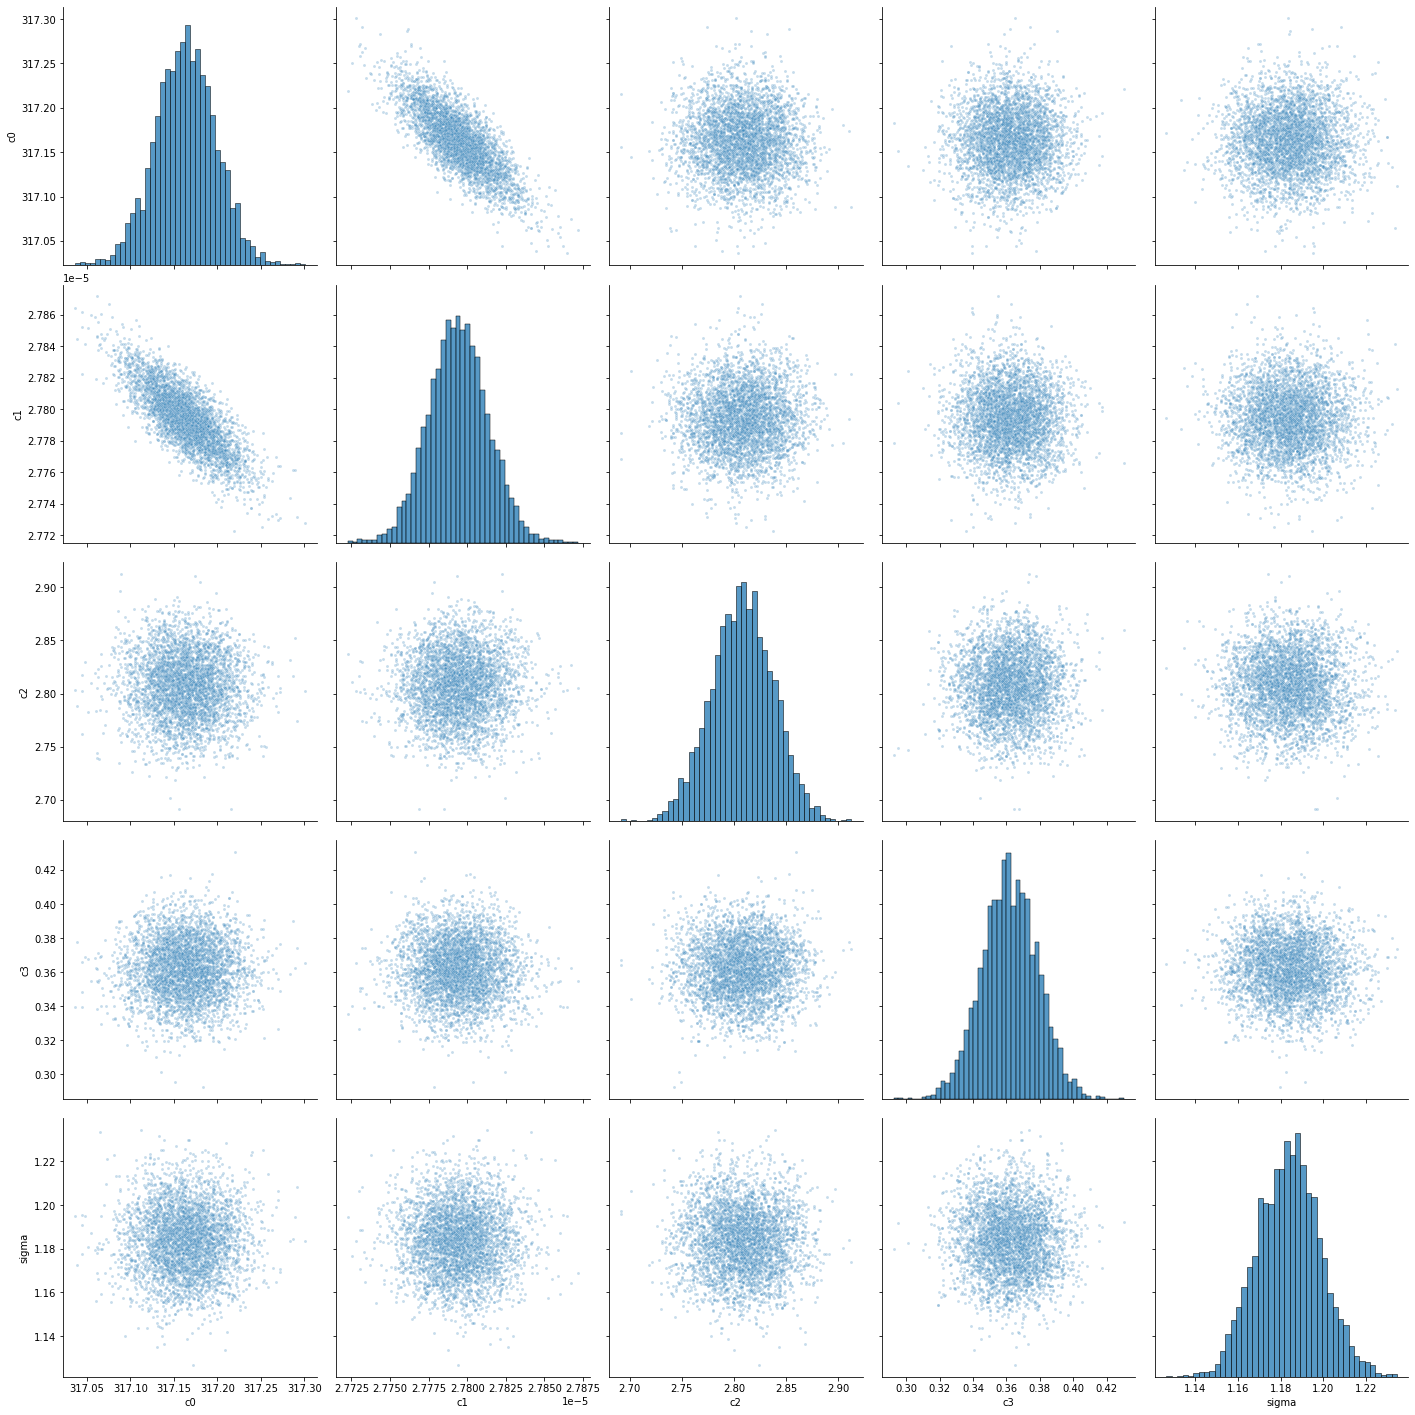

In [ ]:
df = pd.DataFrame(
    data=np.transpose([exponential_samples[param] for param in parameters]),
    columns=parameters)
seaborn.pairplot(df, size=4, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()

In [ ]:
print(results_linear)
print(results_quadratic)
print(results_exponential)

Inference for Stan model: anon_model_49db1dce028ad8b3bce2656be0e98833.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c0    305.66  2.2e-3   0.14 305.39 305.57 305.66 305.76 305.94   4055    1.0
c1    4.4e-3  1.6e-7 1.1e-5 4.3e-3 4.4e-3 4.4e-3 4.4e-3 4.4e-3   4088    1.0
c2      2.78  2.0e-3    0.1   2.59   2.71   2.78   2.85   2.97   2353    1.0
c3      0.35  1.2e-3   0.06   0.24   0.31   0.35   0.39   0.46   2251    1.0
sigma   4.01  9.8e-4   0.05   3.91   3.98   4.01   4.04   4.11   2595    1.0
lp__   -6077    0.04   1.57  -6081  -6078  -6077  -6076  -6075   1521    1.0

Samples were drawn using NUTS at Fri Apr 16 22:38:19 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
Inference for Stan model: anon_model_9b5f0ad1b1db

In [ ]:
#defining the test statistics for model checking
def test_statistic_1(data):
  return data[1500]-data[0]

def test_statistic_2(data):
  return np.mean(data)

def test_statistic_3(data):
  return data[-1] - data[-1500]

In [ ]:
#generating data samples using paramters of the linear model
#and calculating test statistic of each sample
replicated_linear = []
ts1_lin = []
ts2_lin = []
ts3_lin = []
for i in range(1000):
  replicated_linear.append(linear(linear_samples, data.iloc[:,2], np.random.choice))
  ts1_lin.append(test_statistic_1(replicated_linear[-1]))
  ts2_lin.append(test_statistic_2(replicated_linear[-1]))
  ts3_lin.append(test_statistic_3(replicated_linear[-1]))

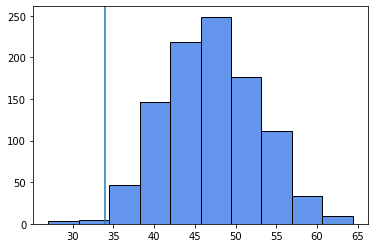

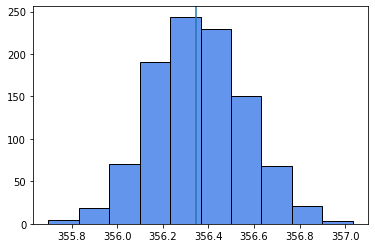

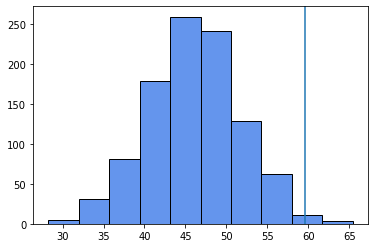

In [ ]:
plt.hist(ts1_lin, edgecolor='black', color='cornflowerblue')
plt.axvline(test_statistic_1(list(data.iloc[:,1])))
plt.show()

plt.hist(ts2_lin, edgecolor='black', color='cornflowerblue')
plt.axvline(test_statistic_2(list(data.iloc[:,1])))
plt.show()

plt.hist(ts3_lin, edgecolor='black', color='cornflowerblue')
plt.axvline(test_statistic_3(list(data.iloc[:,1])))
plt.show()

In [ ]:
#generating data samples using paramters of the quadratic model
#and calculating test statistic of each sample
replicated_quadratic = []
ts1_quad = []
ts2_quad = []
ts3_quad = []
for i in range(1000):
  replicated_quadratic.append(quadratic(quadratic_samples, data.iloc[:,2], np.random.choice))
  ts1_quad.append(test_statistic_1(replicated_quadratic[-1]))
  ts2_quad.append(test_statistic_2(replicated_quadratic[-1]))
  ts3_quad.append(test_statistic_3(replicated_quadratic[-1]))

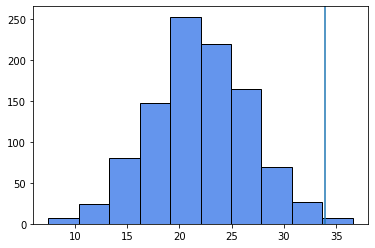

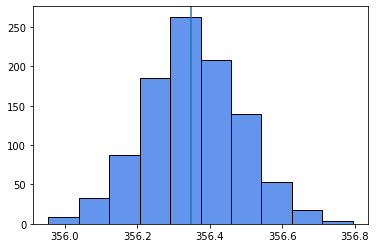

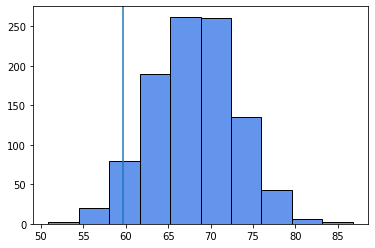

In [ ]:
plt.hist(ts1_quad, edgecolor='black', color='cornflowerblue')
plt.axvline(test_statistic_1(list(data.iloc[:,1])))
plt.show()

plt.hist(ts2_quad, edgecolor='black', color='cornflowerblue')
plt.axvline(test_statistic_2(list(data.iloc[:,1])))
plt.show()

plt.hist(ts3_quad, edgecolor='black', color='cornflowerblue')
plt.axvline(test_statistic_3(list(data.iloc[:,1])))
plt.show()

In [ ]:
#generating data samples using paramters of the exponential model
#and calculating test statistic of each sample
replicated_exponential = []
ts1_exp = []
ts2_exp = []
ts3_exp = []
for i in range(1000):
  replicated_exponential.append(exponential(exponential_samples, data.iloc[:,2], np.random.choice))
  ts1_exp.append(test_statistic_1(replicated_exponential[-1]))
  ts2_exp.append(test_statistic_2(replicated_exponential[-1]))
  ts3_exp.append(test_statistic_3(replicated_exponential[-1]))

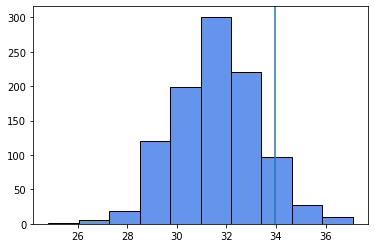

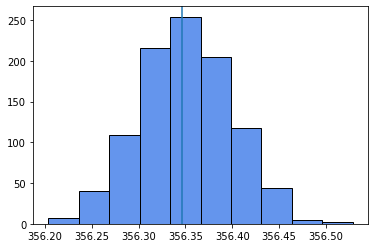

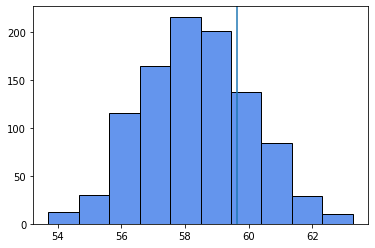

In [ ]:
plt.hist(ts1_exp, edgecolor='black', color='cornflowerblue')
plt.axvline(test_statistic_1(list(data.iloc[:,1])))
plt.show()

plt.hist(ts2_exp, edgecolor='black', color='cornflowerblue')
plt.axvline(test_statistic_2(list(data.iloc[:,1])))
plt.show()

plt.hist(ts3_exp, edgecolor='black', color='cornflowerblue')
plt.axvline(test_statistic_3(list(data.iloc[:,1])))
plt.show()

In [ ]:
#creating a list of future days (every 7 days)
future = np.arange(data.iloc[-1, 2]+7, data.iloc[-1, 2]+15007, 7)
current_days = pd.DataFrame({'Column 1':days})
future_days = pd.DataFrame({'Column 2':future})
prediction_data_ = current_days['Column 1'].append(future_days['Column 2']).reset_index(drop=True)

prediction_data = prediction_data_.to_frame()
prediction_data['CO2'] = data.iloc[:,1]

In [ ]:
stan_code_exponential_predictive = """

data {  
    int<lower=0> N_obs;      // length of the data (number of prices)
    int<lower=0> N_future;    // number of future days
    real<lower=0> obs[N_obs];   // specific observations
    real<lower=0> day[N_obs];       // day
    real<lower=0> day_future[N_future];  //futuure days for which we need to create data
}

parameters {
    //parameters of the model
    real<lower=0> c0;   
    real<lower=0> c1;  
    real<lower=0, upper=10> c2;
    real<lower=0, upper=1> c3;          
    real<lower=0> sigma;            
}


model {
    //priors 
    c0 ~ cauchy(0, 1);
    c1 ~ cauchy(0, 1); 
    c2 ~ cauchy(0, 1);
    c3 ~ cauchy(0, 1);
    sigma ~ cauchy(0, 1);

    //likelihood
    for (i in 1:N_obs) {
      obs[i] ~ normal(c0+c1*(day[i]^1.5)+c2*cos(2*pi()*day[i]/(365.25+c3)), sigma);
    }

}

generated quantities {
  real x_future[N_future];
  for(t in 1:N_future) {
    x_future[t] = normal_rng(c0+c1*(day_future[t]^1.5)+c2*cos(2*pi()*day_future[t]/(365.25+c3)), 
    sigma);
  }
}
"""
stan_model_exponential_predictive = pystan.StanModel(model_code=stan_code_exponential_predictive)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b5adeb1bfd82b36dd76b8d475528ae17 NOW.


In [ ]:
stan_data_predictive = {
  'N_obs': len(data),
  'N_future': len(future_days),
  'obs': prediction_data.iloc[:3209,1],
  'day': prediction_data.iloc[:3209,0],
  'day_future': prediction_data.iloc[3209:,0]
}

results_predictive = stan_model_exponential_predictive.sampling(data=stan_data_predictive)
samples_predictive = results_predictive.extract()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [ ]:
#getting the samples of the future data
#and their 95% confidence intervals
prediction = samples_predictive['x_future']
prediction_interval = np.percentile(prediction, axis=0, q=[2.5, 97.5])

In [ ]:
#averaging out predictions from 4000 samples
prediction_values = []
for i in range(len(prediction[0])):
  value = 0
  for k in range(4000):
    value+=prediction[k][i]
  prediction_values.append(value/4000)

In [ ]:
#generating dats for each day in the future to add them to a new table
dates = ['2021-02-13']
for i in range(len(future_days)):
  begindatestr = dates[-1]
  begindate = datetime.strptime(begindatestr, "%Y-%m-%d")
  enddate = begindate + timedelta(days=7)
  dates.append(datetime.strftime(enddate, "%Y-%m-%d"))

In [ ]:
#updating the prediction dataset for better readibility
prediction_data['Date'] = list(data.iloc[:, 0])+dates[1:]
prediction_data.columns =['Day', 'CO2', 'Date']
prediction_data

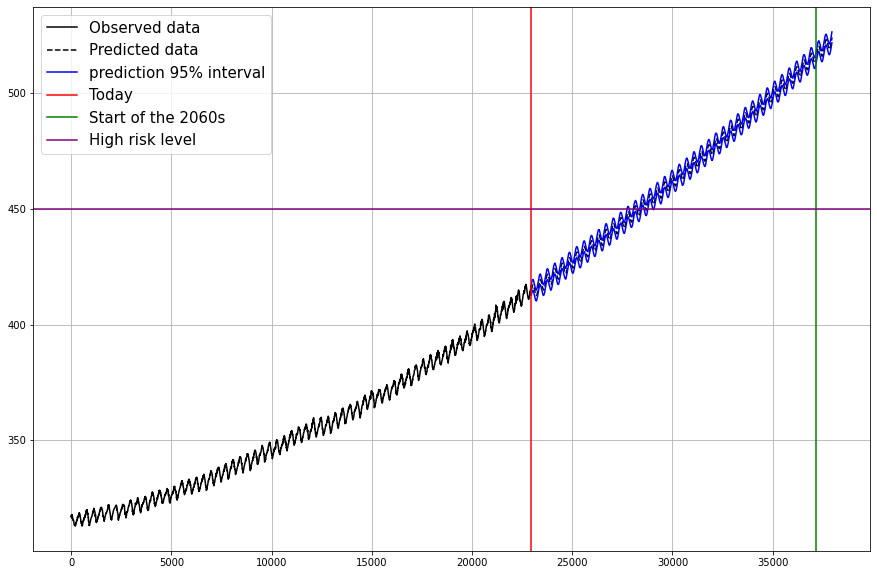

In [ ]:
#plotting the main prediction figure along with 95% confidence intervals
plt.figure(figsize=(15,10))
plt.plot(days, data.iloc[:,1], 'k-', label='Observed data')
plt.plot(future_days, prediction_values, 'k--', label='Predicted data')
plt.plot(
    range(days[-1], 37961, 7), prediction_interval[0,:],
    'b-', label='prediction 95% interval')
plt.plot(
    range(days[-1], 37961, 7), prediction_interval[1,:],
    'b-')
plt.axvline(days[-1], color='red', label='Today')
plt.axvline(37163, color='green', label='Start of the 2060s')
plt.axhline(450, color='purple', label='High risk level')
plt.grid()
plt.legend(fontsize=15)
plt.show()

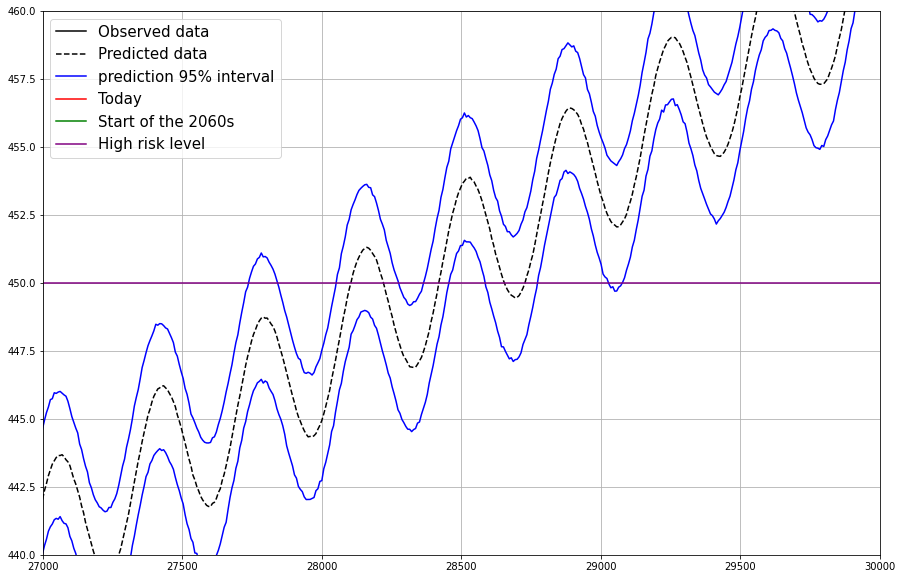

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(days, data.iloc[:,1], 'k-', label='Observed data')
plt.plot(future_days, prediction_values, 'k--', label='Predicted data')
plt.plot(
    range(days[-1], 37961, 7), prediction_interval[0,:],
    'b-', label='prediction 95% interval')
plt.plot(
    range(days[-1], 37961, 7), prediction_interval[1,:],
    'b-')
plt.axvline(days[-1], color='red', label='Today')
plt.axvline(37163, color='green', label='Start of the 2060s')
plt.axhline(450, color='purple', label='High risk level')
plt.grid()
plt.legend(fontsize=15)
plt.axis([27000, 30000, 440, 460])
plt.show()


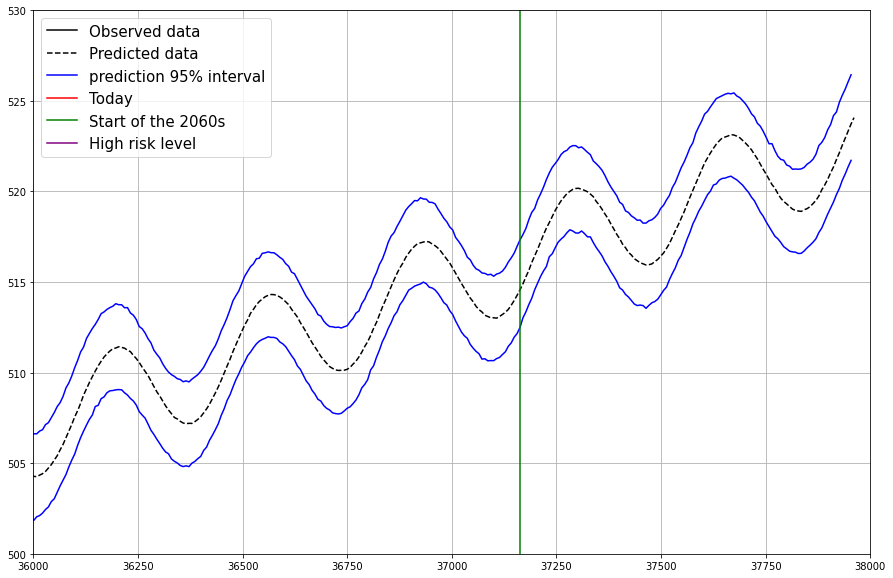

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(days, data.iloc[:,1], 'k-', label='Observed data')
plt.plot(future_days, prediction_values, 'k--', label='Predicted data')
plt.plot(
    range(days[-1], 37961, 7), prediction_interval[0,:],
    'b-', label='prediction 95% interval')
plt.plot(
    range(days[-1], 37961, 7), prediction_interval[1,:],
    'b-')
plt.axvline(days[-1], color='red', label='Today')
plt.axvline(37163, color='green', label='Start of the 2060s')
plt.axhline(450, color='purple', label='High risk level')
plt.grid()
plt.legend(fontsize=15)
plt.axis([36000, 38000, 500, 530])
plt.show()